# Classify URLs into Benign or Not Benign

## Overview

- **Goal:** With data sourced from [Kaggle](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset), classify a url as being benign or not benign. 

- **Process:** Exploring the data, there were only 2 columns:
  - url
  - type

  Since there was a lack of features, I explored ways to feature engineer the existing data into something more viable. Post EDA, feature engineering, and sampling to make a more balanced dataset, the shape of the data ended up being `(200000, 11)` with a 50/50 split of benign and not benign types (before the train-test-split). The dependant variable is `type` (**benign = 1** while **not benign = 0**). Independant variables feature engineered are items such as count of vowels and consants, length of root domain, count of subdomains, etc.

  From that point, 4 models were instantiated and predictions were made on the test data. The 4 models were:
  - logistic regression
  - k-nearest neighbors
  - decision tree
  - random forest

- **Visuals**: The visualization chosen for this data to begin with is a line chart detailing a `ROC Curve Comparison Across 4 Models` for the false positive rate as `x` and true positive rate as `y`.

* **Conclusion**: Although the original data didn't have enough features, it ended up to have a minimum to get the models to seem to score well with the features created from the url traits. Originally I was going to get much more data but ended up starting with just what is here in this MVP. If later on the metrics don't make sense, I'll revisit putting more items in from external sources such as domain registrant information, time from domain was registered, maybe others. Overall, the scores seem balanced between accuracy and precision except for logistic regression. The best model for this task is random forest with the scores below under the `Metrics` section along with a line chart.

## EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings

In [2]:
sns.set()
warnings.filterwarnings('ignore')

pd.options.display.max_columns=100
pd.options.display.max_rows=10

In [3]:
df = pd.read_csv("urls.csv")
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [4]:
print("Shape:\n", df.shape)
print("Columns:\n", df.columns)
print("Dtypes:\n", df.dtypes)

Shape:
 (651191, 2)
Columns:
 Index(['url', 'type'], dtype='object')
Dtypes:
 url     object
type    object
dtype: object


In [5]:
# lowercase all
# ref: https://stackoverflow.com/a/50084009
df.rename(columns=str.lower, inplace=True)
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

# clean spaces off urls
df['url'] = [val.strip() for val in df['url'].values]

In [6]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [7]:
# drop "defacement" as it's not necessarily setup to be malicous but more of a temp site compromise - could throw off predictions as the original site wasn't made that way
df.drop(df[df['type'] == "defacement"].index, inplace=True)

# drop "phishing" as the dataset contained a lot of known of legit sites - most likely used in a body of an email that has an actual hyperlink to another site
df.drop(df[df['type'] == "phishing"].index, inplace=True)

# rename values to a common 'not_benign' and clean some prelim values like http
df['type'].replace(['malware'], 'not_benign', inplace=True)
df['url'].replace(to_replace=r"^https?:?/?/?", value=r"", regex=True, inplace=True)
df['url'].replace(to_replace=r"^www\.", value=r"", regex=True, inplace=True)
df['url'].replace(to_replace=r"/$", value=r"", regex=True, inplace=True)

# filter only urls with uri
df = df.loc[df['url'].str.contains("/")]

# dedup
df.drop_duplicates(inplace=True)

In [8]:
# split out the url into 6 parts and start count or length measurements
# ref: https://datascienceparichay.com/article/pandas-split-column-by-delimiter/
df[['domain', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5', 'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10']] = df['url'].str.split('/', n=10, expand=True)

# count of total dir_x
df['count_of_dirs'] = [len(item) for item in df['url'].str.split('/')]

# ref: https://stackoverflow.com/questions/37335598/how-to-get-the-length-of-a-cell-value-in-pandas-dataframe
df['subdomain_count'] = df['domain'].str.count('\.') - 1

# get length for cell values and make own column
for c in df[['domain', 'url', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5', 'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10']]:
    df[c + '_len'] = df[c].str.len()

# fill NaNs
for c in df[['domain_len', 'url_len', 'dir_1_len', 'dir_2_len', 'dir_3_len', 'dir_4_len', 'dir_5_len', 'dir_6_len', 'dir_7_len', 'dir_8_len', 'dir_9_len', 'dir_10_len']]:
    #df[c].fillna(np.nanmedian(df[c]), inplace=True)
    df[c].fillna(0, inplace=True)

In [9]:
# count vowels, consanants, numbers, and hyphens
# ref: https://stackoverflow.com/questions/49234374/how-to-count-vowels-and-consonants-in-pandas-dataframe-both-uppercase-and-lower
df['domain_vowel_count'] = df['domain'].str.count(r'[aeiou]')
df['domain_consonant_count'] = df['domain'].str.count(r'[a-z]') - df['domain_vowel_count']
df['domain_number_count'] = df['domain'].str.count(r'[0-9]')
df['domain_hyphen_count'] = df['domain'].str.count("-")

# fill NaNs
for c in df[['domain_vowel_count', 'domain_consonant_count', 'domain_number_count', 'domain_hyphen_count']]:
    df[c].fillna(0, inplace=True)

In [10]:
# attempt for tld verification - tightens up the dataset too much so not using

# get details of subdomains
#tld_list = pd.read_csv("tld_list.txt", header=None)
#tld_list[0].replace(to_replace=r"^\.", value="r'(.", regex=True, inplace=True)
#tld_list[0].replace(to_replace=r"$", value="$)'", regex=True, inplace=True)
#tld_list = tld_list[0].str.lower().to_list()

# make into one big or regex
# ref: https://stackoverflow.com/questions/13174468/how-do-you-join-all-items-in-a-list
#tld_pattern = '|'.join(str(v) for v in tld_list)

# ref: https://towardsdatascience.com/8-ways-to-filter-a-pandas-dataframe-by-a-partial-string-or-pattern-49f43279c50f
#df = df[df['domain'].str.contains(tld_pattern, case=True, na=False)]

In [11]:
# benign = 1
# not_benign = 0
df['type'].replace(['benign'], 1, inplace=True)
df['type'].replace(['not_benign'], 0, inplace=True)

In [12]:
df.sample(5, random_state=42).style

,url,type,domain,dir_1,dir_2,dir_3,dir_4,dir_5,dir_6,dir_7,dir_8,dir_9,dir_10,count_of_dirs,subdomain_count,domain_len,url_len,dir_1_len,dir_2_len,dir_3_len,dir_4_len,dir_5_len,dir_6_len,dir_7_len,dir_8_len,dir_9_len,dir_10_len,domain_vowel_count,domain_consonant_count,domain_number_count,domain_hyphen_count
296947,winters-online.net/bishopmeredith/ui05.htm,1,winters-online.net,bishopmeredith,ui05.htm,None,None,None,None,None,None,None,None,3,0,18,42,14,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,10,0,1
268141,nwda-db.wsulibs.wsu.edu/findaid/ark:/80444/xv59509,1,nwda-db.wsulibs.wsu.edu,findaid,ark:,80444,xv59509,None,None,None,None,None,None,5,2,23,50,7,4.000000,5.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,13,0,1
546941,125.41.9.81:55499/mozi.m,0,125.41.9.81:55499,mozi.m,None,None,None,None,None,None,None,None,None,2,2,17,24,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,13,0
425750,jango.com/music/burt+bacharach?l=0,1,jango.com,music,burt+bacharach?l=0,None,None,None,None,None,None,None,None,3,0,9,34,5,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,5,0,0
256006,pornsharing.com/lex-steele-gets-his-big-black-sausage-eaten-by-buxom-kimberly-kendall-pov-style_v78247,1,pornsharing.com,lex-steele-gets-his-big-black-sausage-eaten-by-buxom-kimberly-kendall-pov-style_v78247,None,None,None,None,None,None,None,None,None,2,0,15,102,86,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,10,0,0


## Models

In [13]:
# ref: https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn import metrics
from collections import Counter

In [14]:
df.columns

Index(['url', 'type', 'domain', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'count_of_dirs',
       'subdomain_count', 'domain_len', 'url_len', 'dir_1_len', 'dir_2_len',
       'dir_3_len', 'dir_4_len', 'dir_5_len', 'dir_6_len', 'dir_7_len',
       'dir_8_len', 'dir_9_len', 'dir_10_len', 'domain_vowel_count',
       'domain_consonant_count', 'domain_number_count', 'domain_hyphen_count'],
      dtype='object')

In [15]:
# define independent and target variables
X = df.loc[:, 'count_of_dirs':'domain_hyphen_count']
y = df['type'].to_frame()

In [16]:
# split X and y into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

df1 = X_train.join(y_train, how='inner')
df1_benign = df1.loc[df1['type'] == 1].sample(10000, random_state=42)
df1_not_benign = df1.loc[df1['type'] == 0].sample(10000, random_state=42)
df1 = pd.concat([df1_benign, df1_not_benign], ignore_index=True)

# define new X_train and y_train with equal sampling (test sets left alone)
X_train = df1.loc[:, 'count_of_dirs':'domain_hyphen_count']
y_train = df1['type']
y_test = pd.Series(y_test['type'])

In [17]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 10000, 0: 10000})
Counter({1: 75782, 0: 4516})


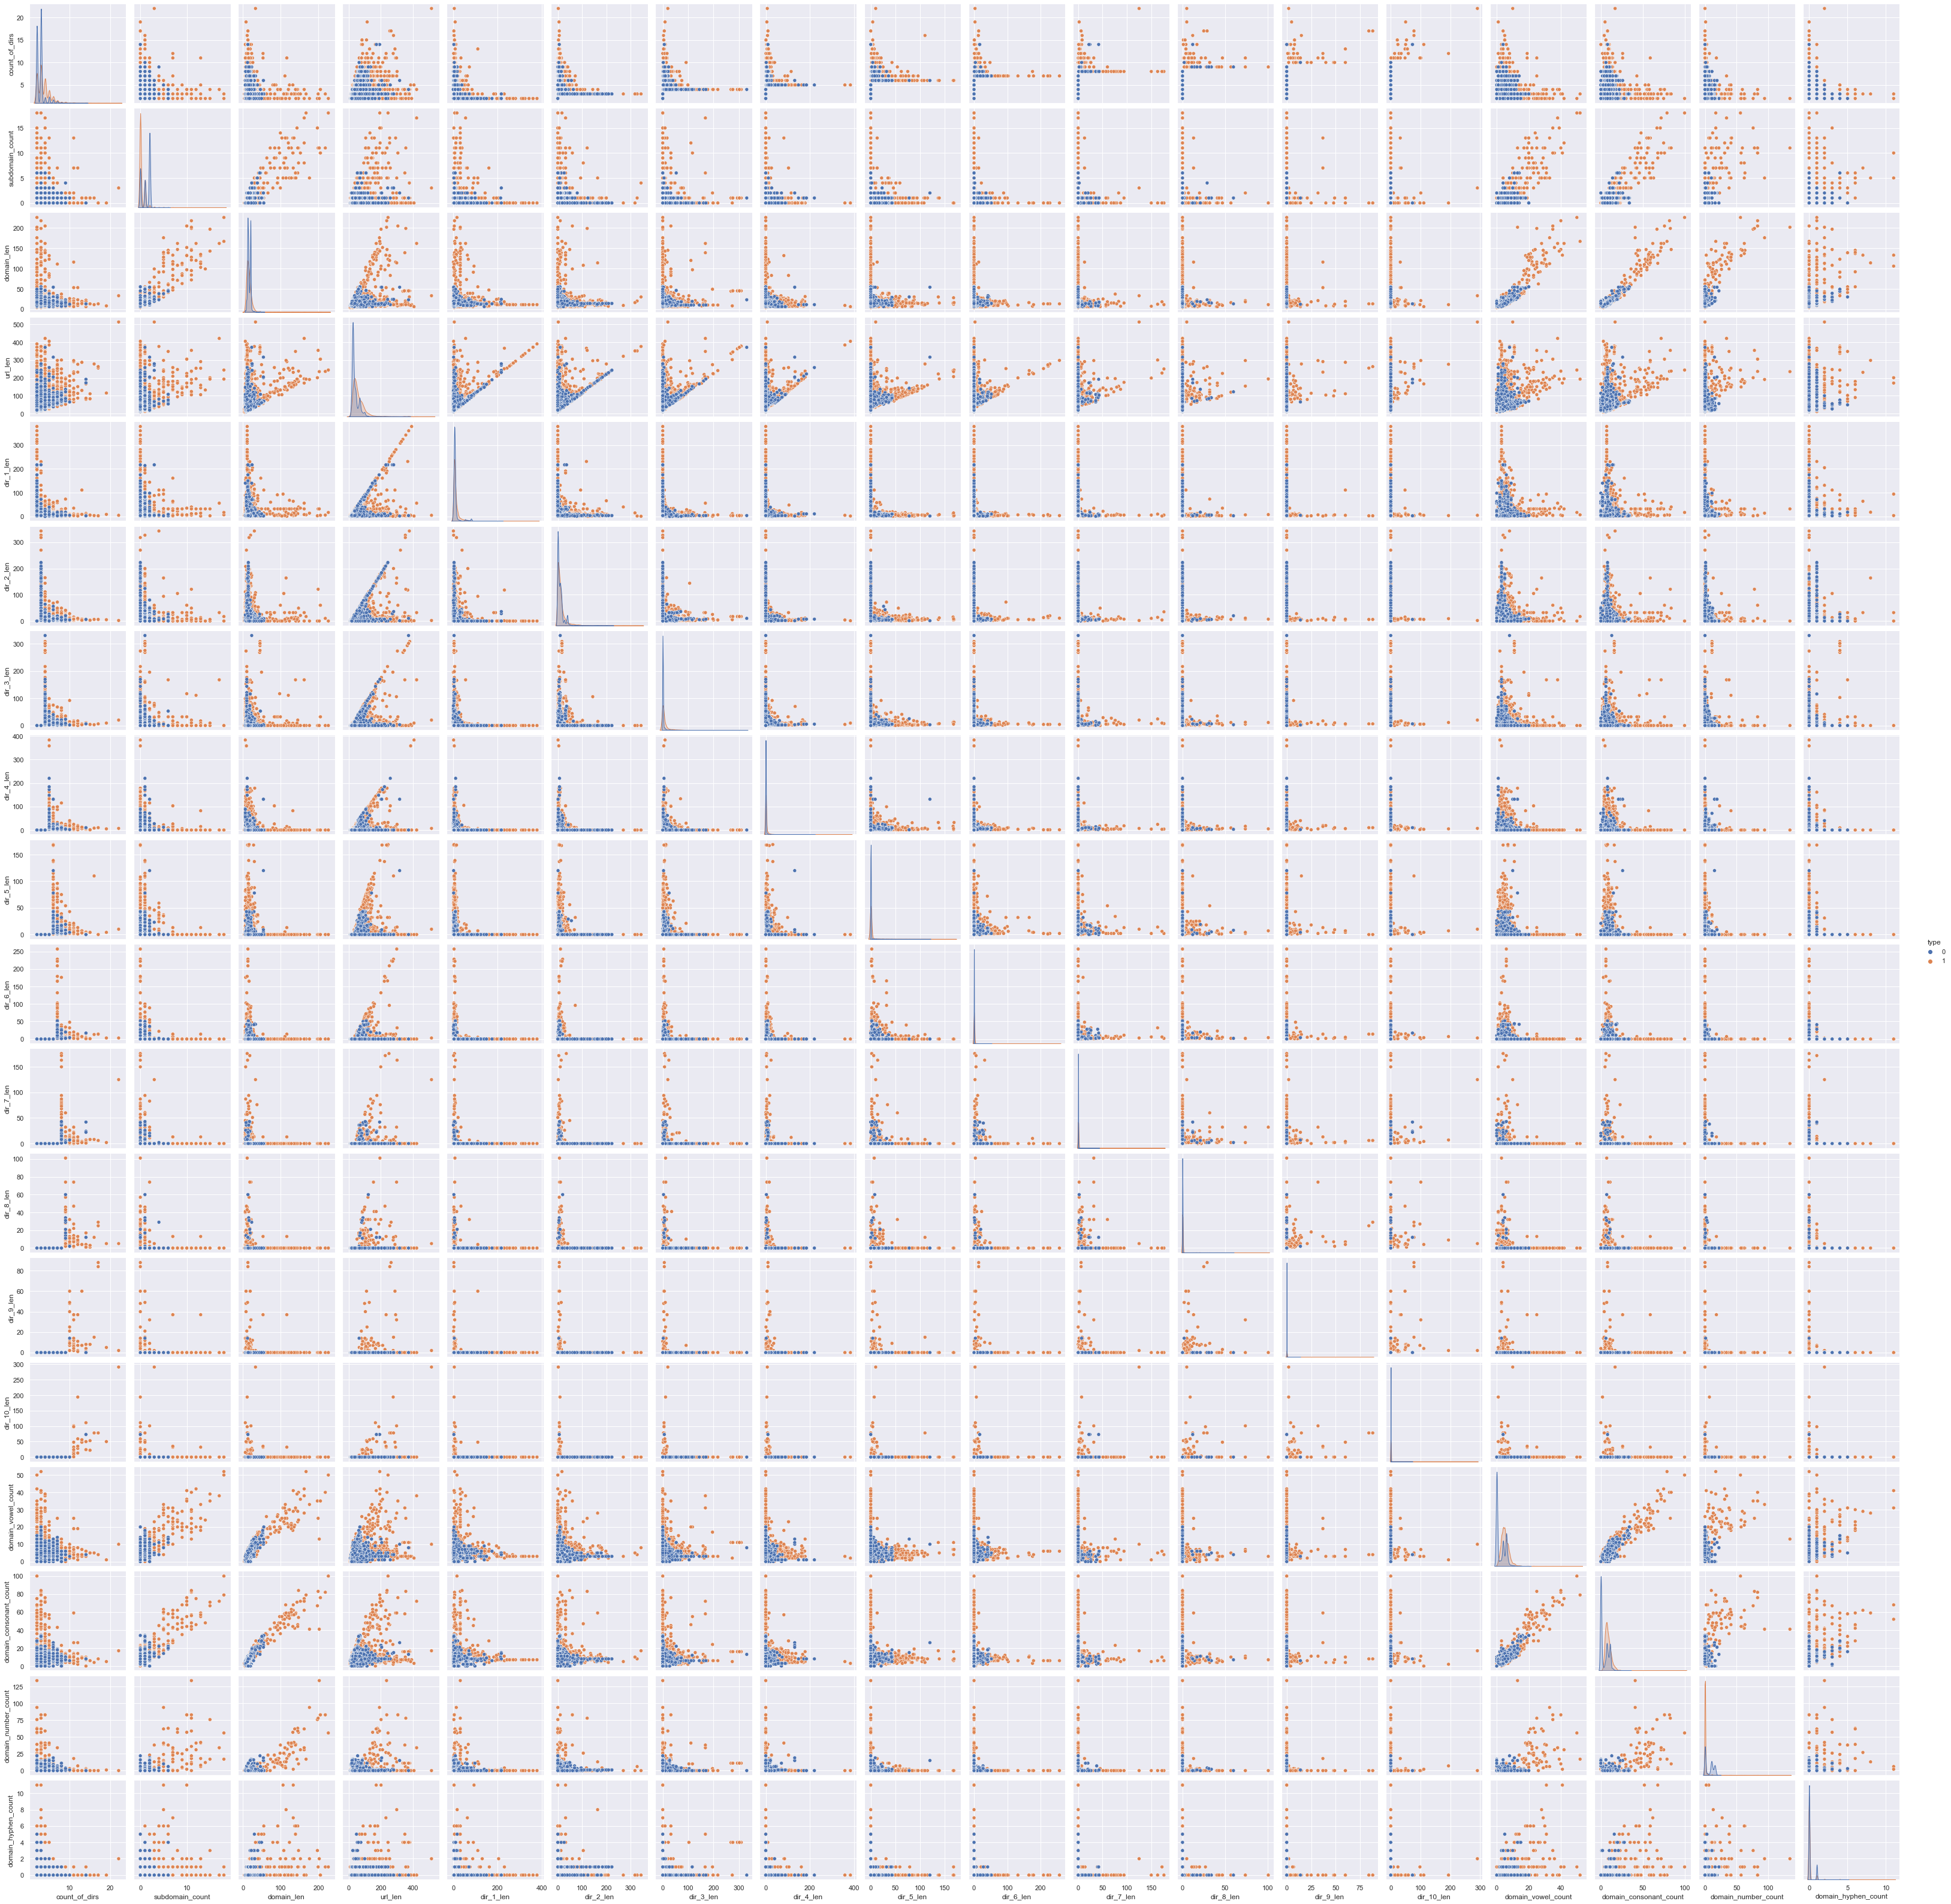

In [18]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue="type");

A lot of code is based on machinelearningmastery.com as well as article from Wei-Meng Lee

ref: 
- https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/
- https://towardsdatascience.com/ensemble-learning-in-sklearn-587f21246e8d

In [19]:
# make baseline models

# knn
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# logr
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# random forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# make class predictor for the X_test (testing) set
y_pred_knn = knn.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_dt = dt.predict(X_test)

In [20]:
# get baseline metrics

def metric_generator(y_test, y_pred):
    for score in accuracy_score, precision_score, recall_score, f1_score:
        print(score.__name__ + ":", score(y_test, y_pred))

for model in lr, knn, dt, rf:
    print(f"\n++ Metrics for {model} ++")
    metric_generator(y_test, model.predict(X_test))


++ Metrics for LogisticRegression(random_state=42) ++
accuracy_score: 0.9131609753667588
precision_score: 0.9806238911473395
recall_score: 0.9262885645667837
f1_score: 0.952682115834832

++ Metrics for KNeighborsClassifier() ++
accuracy_score: 0.9421156193180403
precision_score: 0.9939312298633485
recall_score: 0.9444327148927186
f1_score: 0.9685499695513905

++ Metrics for DecisionTreeClassifier(random_state=42) ++
accuracy_score: 0.9255398640065755
precision_score: 0.9958796868562011
recall_score: 0.92492940276055
f1_score: 0.9590941743919543

++ Metrics for RandomForestClassifier(random_state=42) ++
accuracy_score: 0.9812697701063539
precision_score: 0.9958477970627503
recall_score: 0.9842574753899342
f1_score: 0.9900187149095446


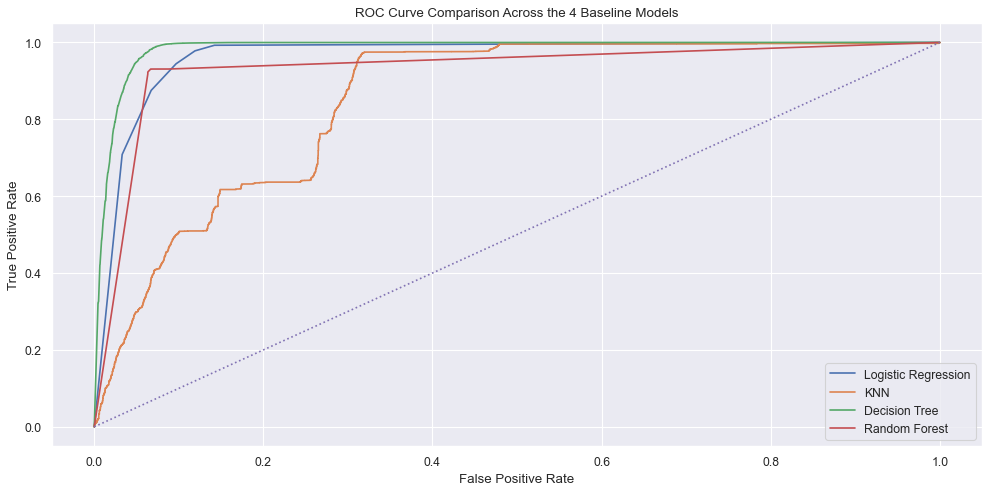

In [21]:
# ref: https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib

figure(figsize=(15, 7), dpi=80)

def tpr_fpr(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    return plt.plot(fpr, tpr)

for model in knn, lr, rf, dt:
    tpr_fpr(model)

x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle=':')
plt.title('ROC Curve Comparison Across the 4 Baseline Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression','KNN', 'Decision Tree', 'Random Forest']);


++ Metrics for KNeighborsClassifier ++
accuracy_score: 0.9255398640065755
precision_score: 0.9958796868562011
recall_score: 0.92492940276055
f1_score: 0.9590941743919543

Training Data Tuned Hyperparameters for KNeighborsClassifier: {'classifier__n_neighbors': 5}
Training Data Accuracy for KNeighborsClassifier: 0.9267000000000001

++ Metrics for LogisticRegression ++
accuracy_score: 0.9255398640065755
precision_score: 0.9958796868562011
recall_score: 0.92492940276055
f1_score: 0.9590941743919543

Training Data Tuned Hyperparameters for LogisticRegression: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Training Data Accuracy for LogisticRegression: 0.8141999999999999

++ Metrics for RandomForestClassifier ++
accuracy_score: 0.9255398640065755
precision_score: 0.9958796868562011
recall_score: 0.92492940276055
f1_score: 0.9590941743919543

Training Data Tuned Hyperparameters for RandomForestClassifier: {'classifier__n_estimators': 300}
Training Da

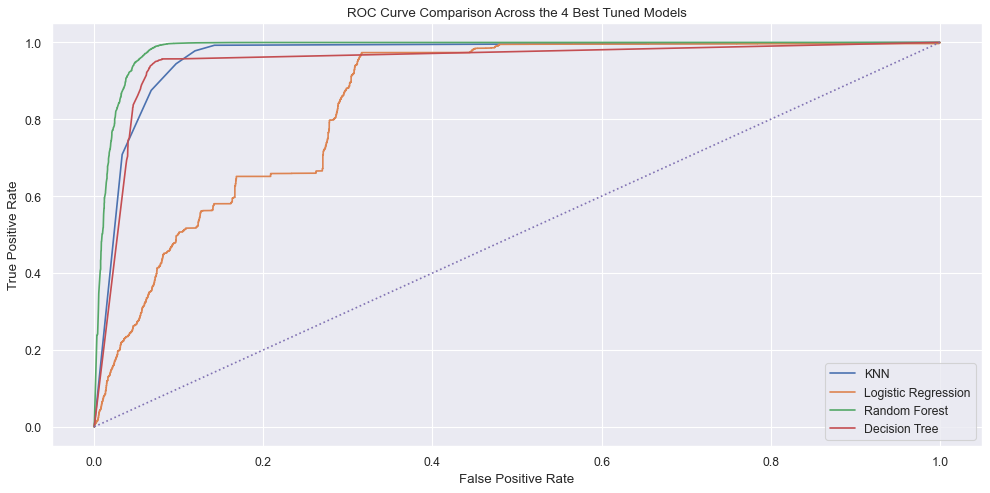

In [22]:
# ref: https://towardsdatascience.com/ensemble-learning-in-sklearn-587f21246e8d

classifiers = [
    KNeighborsClassifier(), 
    LogisticRegression(random_state=42), 
    RandomForestClassifier(random_state=42), 
    DecisionTreeClassifier(random_state=42)
]

# parameter grids for the classifiers
knn_params = {
    'classifier__n_neighbors': np.arange(1, 25, 2)
}

logr_params = {
    'classifier__penalty' : ['l1', 'l2'],     
    'classifier__C'       : np.logspace(-3,3,7),
    'classifier__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

rf_params = {
    'classifier__n_estimators': [50, 100, 200, 300]
}

dt_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': np.arange(1, 25, 2)
}

parameters = [knn_params, logr_params, rf_params, dt_params]

# store all the tuned estimators
estimators = []

# for viz
figure(figsize=(15, 7), dpi=80)

# iterate through each of the 4 classifier and use GridSearchCV
for i, classifier in enumerate(classifiers):
    # create a Pipeline object
    pipe = Pipeline([('classifier', classifier)])
    grid = GridSearchCV(pipe, param_grid=parameters[i], scoring='accuracy', cv=10)
    grid.fit(X_train, y_train)
    
    def metric_generator(y_test, y_pred):
        for score in accuracy_score, precision_score, recall_score, f1_score:
            print(score.__name__ + ":", score(y_test, y_pred))
    
    print(f"\n++ Metrics for {classifier.__class__.__name__} ++")
    metric_generator(y_test, model.predict(X_test))

    def tpr_fpr(model):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        return plt.plot(fpr, tpr)
    
    tpr_fpr(grid)
    
    print(f"\nTraining Data Tuned Hyperparameters for {classifier.__class__.__name__}:", grid.best_params_)
    print(f"Training Data Accuracy for {classifier.__class__.__name__}:", grid.best_score_)
    
    # add the grid to the estimators list
    estimators.append((classifier.__class__.__name__, grid))

x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle=':')
plt.title('ROC Curve Comparison Across the 4 Best Tuned Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['KNN', 'Logistic Regression', 'Random Forest', 'Decision Tree']);

In [23]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)

# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)
 
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
print(result_df.columns)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 17}
Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=42))])
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__criterion', 'param_classifier__max_depth', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


In [24]:
# make an ensemble based on a voting classifier
ensemble = VotingClassifier(estimators, voting='soft', weights=[1, 1, 1, 1]) # all 4 models get equal weight
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('KNeighborsClassifier',
                              GridSearchCV(cv=10,
                                           estimator=Pipeline(steps=[('classifier',
                                                                      KNeighborsClassifier())]),
                                           param_grid={'classifier__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
                                           scoring='accuracy')),
                             ('LogisticRegression',
                              GridSearchCV(cv=10,
                                           estimator=Pipeline(steps=[('classifier',
                                                                      LogisticRegression(random_state...
                                           param_grid={'classifier__n_estimators': [50,
                                                                                    100,
                                          

In [25]:
ensemble.score(X_test, y_test)

0.9797877904804603

In [26]:
# ref: 365 Data Science, ML in Python course, section 4.9
def confusion_matrix_custom(data, actual_values, model):
        
        # Confusion matrix 
                
        # Predict the values using the ensemble model
        pred_values = model.predict(data)
        # Specify the bins 
        bins=np.array([0,0.5,1])
        # Create a histogram, where if values are between 0 and 0.5 tell will be considered 0
        # if they are between 0.5 and 1, they will be considered 1
        cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
        # Calculate the accuracy
        accuracy = (cm[0,0]+cm[1,1]) / cm.sum()
        # Return the confusion matrix and the accuracy
        return cm #, accuracy

In [27]:
cm_rez = confusion_matrix_custom(X_test, y_test, ensemble)

In [28]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 10000, 0: 10000})
Counter({1: 75782, 0: 4516})


In [29]:
# make a df on the confusion matrix for display
cm_df = pd.DataFrame(cm_rez)
cm_df.columns = ['Predicted 0','Predicted 1']
cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,4156.0,360.0
Actual 1,1263.0,74519.0


In [30]:
grid.best_params_

{'classifier__criterion': 'entropy', 'classifier__max_depth': 17}